# 1. Data preparation

In [1]:
%load_ext autoreload
%autoreload 2

from data.datasets import TrainingPicassoDataset
from config.datasets import dataset_configs

z_range = 1000
dataset = 'picasso_test'
train_dataset = TrainingPicassoDataset(dataset_configs[dataset]['training'], z_range)

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 5]



Loaded spots...


  0%|          | 0/93 [00:00<?, ?it/s]

Aligning (94, 41, 31, 31) psfs...


100%|██████████| 93/93 [00:18<00:00,  5.05it/s]


Prepared stacks...
masking
Adding noise... 30
0.0 2290.7545568738624
195 2110
195 1648
Standardising using
 	mean: 0.003320366880867502
 	std 0.0007165275906944611


In [2]:
import numpy as np
from skimage.transform import resize

for k in train_dataset.data.keys():
#     train_dataset.data[k][0][0] = np.repeat(train_dataset.data[k][0][0], 3, axis=-1)
    train_dataset.data[k][0][0] = np.stack([resize(img, (32, 32, 1), anti_aliasing=True) for img in train_dataset.data[k][0][0]])
    print(train_dataset.data[k][0][0].shape)

(77345, 32, 32, 1)
(713, 32, 32, 1)
(357, 32, 32, 1)


# 2. Training the model


In [3]:
TRAIN_NEW_MODEL = True

In [4]:
# resnet34


In [5]:
# class ResBlock(Model):
#     def __init__(self, channels, stride=1, name='ResBlock'):
#         super(ResBlock, self).__init__(name=name)
#         self.flag = (stride != 1)
#         self.conv1 = Conv2D(channels, 3, stride, padding='same')
#         self.bn1 = BatchNormalization()
#         self.conv2 = Conv2D(channels, 3, padding='same')
#         self.bn2 = BatchNormalization()
#         self.relu = ReLU()
#         if self.flag:
#             self.bn3 = BatchNormalization()
#             self.conv3 = Conv2D(channels, 1, stride)

#     def call(self, x):
#         x1 = self.conv1(x)
#         x1 = self.bn1(x1)
#         x1 = self.relu(x1)
#         x1 = self.conv2(x1)
#         x1 = self.bn2(x1)
#         if self.flag:
#             x = self.conv3(x)
#             x = self.bn3(x)
#         x1 = Layers.add([x, x1])
#         x1 = self.relu(x1)
#         return x1
    
# def resnet_model(bound):
#     print(f'Loading functional resnet with bound {bound}')
#     img_input = Input((bound, bound, 3))
#     coords_input = Input((2,))
# #     augment_data = Sequential([
# #         RandomTranslation(1/bound, 1/bound)
# #     ])
    
#     feature_extraction = Sequential([
#         Conv2D(64, 7, 2, padding='same'),
#         BatchNormalization(),
#         ReLU(),
#         MaxPooling2D(3, 2),
#         ResBlock(64, name='ResBlock64_1'),
#         ResBlock(64, name='ResBlock64_2'),
#         ResBlock(64, name='ResBlock64_3'),
#         ResBlock(128, 2, name='ResBlock128_1'),
#         ResBlock(128, name='ResBlock128_2'),
#         ResBlock(128, name='ResBlock128_3'),
#         ResBlock(128, name='ResBlock128_4'),
#         ResBlock(256, 2, name='ResBlock256_1'),
#         ResBlock(256, name='ResBlock256_2'),
#         ResBlock(256, name='ResBlock256_3'),
#         ResBlock(256, name='ResBlock256_4'),
#         ResBlock(256, name='ResBlock256_5'),
#         ResBlock(256, name='ResBlock256_6'),
#         ResBlock(512, 2, name='ResBlock512_1'),
#         ResBlock(512, name='ResBlock512_2'),
#         ResBlock(512, name='ResBlock512_3'),
#         GlobalAveragePooling2D()
#     ])
    
#     mlp = Sequential([
#         Dense(1024),
#         Dropout(0.5),
#         Dense(1024),
#         Dropout(0.5),
#         Dense(1)
#     ])
    
# #     x = augment_data(img_input)
#     x = feature_extraction(img_input)
#     x = mlp(x)
    
#     model =  Model(inputs=img_input, outputs=x)
#     model.compile(loss='mean_squared_error',optimizer=keras.optimizers.Adam(learning_rate=lr, decay=1e-6),metrics=['mean_absolute_error'])

#     return model


In [6]:
####
# ResNet50V2
# Mean error 27.99669260727733
# std error 22.314346799801278

# ResNet101V2
# Mean error 22.672933114202397
# std error 15.972837859084999


In [7]:
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization, ReLU
from tensorflow.keras import Model, Sequential
from tensorflow.keras import layers as Layers
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D, Conv2D
from tensorflow import keras

bound = 32
def get_pretrained_model():
    img_input_shape = (bound, bound, 1)
    img_input = Input(img_input_shape)
    coords_input = Input((2,))

    resnet = tf.keras.applications.resnet_v2.ResNet101V2(
            include_top=False,
            weights=None,
            pooling='avg',
            input_shape=img_input_shape
        )
    x = resnet(img_input)
    
    print(x.shape)

    mlp = Sequential([
        Dense(1024),
        Dropout(0.5),
        Dense(1024),
        Dropout(0.5),
        Dense(1)
    ])
    x = tf.concat((x, coords_input), axis=1)
    x = mlp(x)
    
    return Model(inputs=(img_input, coords_input), outputs=x)

model = get_pretrained_model()
lr=0.01
model.compile(loss='mean_squared_error',optimizer=keras.optimizers.Adam(learning_rate=lr, decay=1e-6),metrics=['mean_absolute_error'])

print(model.summary())

(None, 2048)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 resnet101v2 (Functional)       (None, 2048)         42620288    ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 tf.concat (TFOpLambda)         (None, 2050)         0           ['resnet101v2[0][0]',            
                                                                  'input_2[0][0]'

In [9]:
%load_ext autoreload
%autoreload 2

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from model.model import load_new_model, save_model, load_trained_model

import numpy as np
import matplotlib.pyplot as plt
from tqdm.keras import TqdmCallback

import os
import logging


bound = train_dataset.data['train'][0][0].shape[1]

BATCH_SIZE = 2**8
LEARNING_RATE = 1e-3

ds_name = dataset
def train_model(dataset, val_dataset=None, pretrained_model=None):

    if not val_dataset:
        val_dataset = dataset['val']
#     for k in dataset:
#         imgs = dataset[k][0][0]
#         norm_imgs = imgs / imgs.max(axis=(1, 2))[:, np.newaxis, np.newaxis]
#         dataset[k][0][0] = norm_imgs

    model = pretrained_model or get_pretrained_model(bound, LEARNING_RATE)

    callbacks = [
        ReduceLROnPlateau(
        monitor='loss', factor=0.1, patience=50, verbose=True,
        mode='min', min_delta=1, cooldown=50, min_lr=1e-7,),
#         ReduceLROnPlateau(
#         monitor='val_mean_absolute_error', factor=0.1, patience=50, verbose=True,
#         mode='min', min_delta=1, cooldown=50, min_lr=1e-10,),
        EarlyStopping(monitor='val_mean_absolute_error', patience=250, verbose=False, min_delta=1, restore_best_weights=True),
#         WandbCallback(save_model=False),
        TqdmCallback(verbose=1),
    ]

    history = model.fit(*dataset['train'], shuffle=True, epochs=5000, verbose=False, batch_size=BATCH_SIZE, validation_data=(*val_dataset,), callbacks=callbacks)
    
    plt.rcParams['figure.figsize'] = [10, 5]
    fig, ax1 = plt.subplots()
    ax1.plot(history.history['mean_absolute_error'], label='mse')
    ax1.plot(history.history['val_mean_absolute_error'], label='val_mse')
    ax1.set_yscale('log')
    ax1.legend(loc=1)
    ax2 = ax1.twinx()
    ax2.plot(history.history['lr'], label='lr')
    ax2.legend(loc=0)

    plt.show()
    return model

if TRAIN_NEW_MODEL:
    model = train_model(train_dataset.data, pretrained_model=model)
else:
    model = load_trained_model(dataset)



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

12/12 [==============================] - 1s 8ms/step
Mean error 19.340576321470973
std error 17.107175989659698


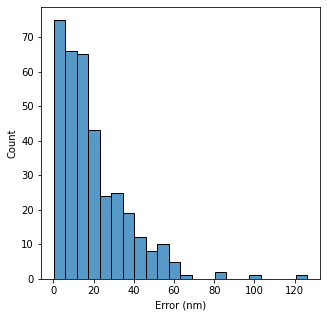

NameError: name 'grid_psfs' is not defined

In [10]:
import seaborn as sns
import random

test_x, test_y = train_dataset.data['test']

pred_y = model.predict(test_x).squeeze()
error = abs(test_y-pred_y)

print(f'Mean error {np.mean(error)}')
print(f'std error {np.std(error)}')

plt.rcParams['figure.figsize'] = [5, 5]
sns.histplot(error)
plt.xlabel('Error (nm)')
plt.show()


idx = np.argsort(error)[::-1][0:1000]
test_imgs = test_x[0].squeeze()[idx]
plt.rcParams['figure.figsize'] = [30, 50]
plt.imshow(grid_psfs(test_imgs))
plt.show()

def snr(img):
    return img.max() / np.median(img)

plt.rcParams['figure.figsize'] = [3, 5]
plt.scatter(test_y, pred_y)
plt.show()
error = abs(pred_y-test_y)
plt.boxplot(error)
plt.show()

plt.scatter([snr(img) for img in test_imgs], error, marker='.', alpha=0.2)
plt.xlabel('snr')
plt.ylabel('error [nm]')
plt.show()

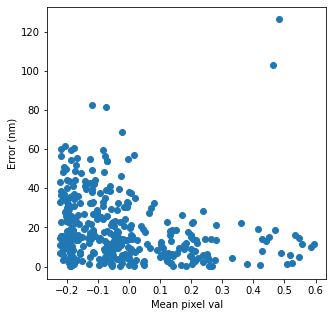

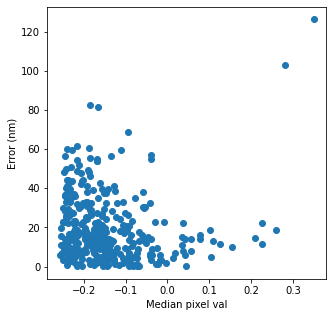

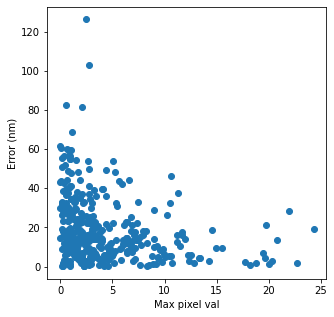

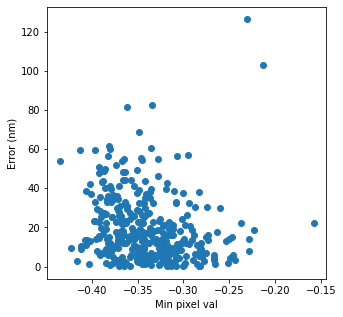

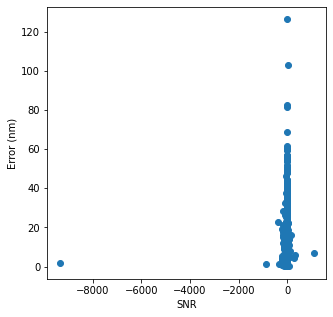

In [12]:
plt.rcParams['figure.figsize'] = [5, 5]
mean_pixel_val = np.mean(test_x[0], axis=(1,2,3))
plt.scatter(mean_pixel_val, error)
plt.xlabel('Mean pixel val')
plt.ylabel('Error (nm)')
plt.show()

median_pixel_val = np.median(test_x[0], axis=(1,2,3))
plt.scatter(median_pixel_val, error)
plt.xlabel('Median pixel val')
plt.ylabel('Error (nm)')
plt.show()

max_pixel_val = np.max(test_x[0], axis=(1,2,3))
plt.scatter(max_pixel_val, error)
plt.xlabel('Max pixel val')
plt.ylabel('Error (nm)')
plt.show()

min_pixel_val = np.min(test_x[0], axis=(1,2,3))
plt.scatter(min_pixel_val, error)
plt.xlabel('Min pixel val')
plt.ylabel('Error (nm)')
plt.show()

snr = [np.max(img) / np.median(img) for img in test_x[0]]
plt.scatter(snr, error)
plt.xlabel('SNR')
plt.ylabel('Error (nm)')
plt.show()

In [ ]:
!nvidia-smi